In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cp drive/My\ Drive/preprocessed_data.csv .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pickle
import tensorflow as tf
import pandas as pd
import html
import re
import string
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from gensim.summarization import summarize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from gensim.summarization import summarize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
train_dataset = pd.read_csv('preprocessed_data.csv')
train_dataset.drop(['Unnamed: 0','Body ID'],axis=1,inplace=True)
train_dataset.head()

,Headline,Stance,articleBody
0,soldier shot near canadian parliament building,unrelated,a small meteorite crashed into a wooded area i...
1,caught a catfish record in po : <number> kg an...,unrelated,a small meteorite crashed into a wooded area i...
2,enormous <number> - stone catfish caught with ...,unrelated,a small meteorite crashed into a wooded area i...
3,soldier shot at war memorial in canada,unrelated,a small meteorite crashed into a wooded area i...
4,a soldier has been shot at canada ’ s war memo...,unrelated,a small meteorite crashed into a wooded area i...


In [0]:
df=train_dataset.copy()

In [0]:
print(df['Headline'][0])

soldier shot near canadian parliament building


In [0]:
print(df['articleBody'][0])

a small meteorite crashed into a wooded area in nicaragua ' s capital of managua overnight , the government said sunday . residents reported hearing a mysterious boom that left a <number> - foot deep crater near the city ' s airport , the associated press reports . government spokeswoman rosario murillo said a committee formed by the government to study the event determined it was a " relatively small " meteorite that " appears to have come off an asteroid that was passing close to earth . " house - sized asteroid <number> rc , which measured <number> feet in diameter , skimmed the earth this weekend , abc news reports . murillo said nicaragua will ask international experts to help local scientists in understanding what happened . the crater left by the meteorite had a radius of <number> feet and a depth of <number> feet , said humberto saballos , a volcanologist with the nicaraguan institute of territorial studies who was on the committee . he said it is still not clear if the meteori

In [0]:
def mark_category(stance):  
    if(stance=='disagree'):    
        return 0
    if(stance=='agree'):
        return 1
    if(stance=='discuss'):
        return 2
    if(stance=='unrelated'):
        return 3

df['labels']=df['Stance'].apply(mark_category)
df.drop(['Stance'],axis=1,inplace=True)

In [0]:
 df['labels'].value_counts()

3    36545
2     8909
1     3678
0      840
Name: labels, dtype: int64

In [0]:

from nltk.stem import WordNetLemmatizer 
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def create_total_text(df):
    sentences = []
    for idx, row in df.iterrows():
        sents_head=tokenizer.tokenize(row[0].strip())
        sents_body=tokenizer.tokenize(row[1].strip())
        for ele in sents_head:
            sentences.append(ele.split())
        for ele in sents_body:
            sentences.append(ele.split())
        
    return sentences

In [0]:
sentences = create_total_text(df)
print(sentences[0])
embed_dim=300

['soldier', 'shot', 'near', 'canadian', 'parliament', 'building']


In [0]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=sentences,size=embed_dim,window=5,min_count=1)
w2v_model.train(sentences,epochs=50,total_examples=len(sentences))                  # embedding of a particular word.
w2v_model.init_sims(replace=True)
w2v_model.save("W2V_epochs_100.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
wevocab=w2v_model.wv.vocab
print(type(vocab))
# print("The total number of words are : ",len(vocab))

<class 'dict'>


In [0]:
print("The no of words :",len(vocab))
# print(vocab)
vocab=list(vocab.keys())
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict))

The no of words : 22495
The no of key-value pairs :  22495


In [0]:

maxi=-1
for i,row in train_dataset.iterrows():
    tokens=row[0].strip().split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
    tokens=row[1].strip().split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

45


In [0]:
t = Tokenizer()
t.fit_on_texts(sentences)
encd_head = t.texts_to_sequences(df['Headline'])
encd_body = t.texts_to_sequences(df['articleBody'])
max_head=30  # max length of a review
max_body=100
vocab_size = len(t.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor
# now padding to have a amximum length of 1565
pad_head= pad_sequences(encd_head, maxlen=max_head, padding='post')
pad_body= pad_sequences(encd_body, maxlen=max_body, padding='post')
pad_head.shape
pad_body.shape
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
from keras.utils.np_utils import to_categorical
y = df['labels'].tolist()
y_cat = np.zeros((len(y),4))
y_cat = to_categorical(y, num_classes=4)
y_cat.shape

(49972, 4)

In [0]:
embed_matrix = np.zeros((vocab_size, embed_dim))
for word,i in t.word_index.items():
    # print(i)
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i] = np.array(embed_vector)
embed_matrix=np.array(embed_matrix)
print(embed_matrix.shape)

(22496, 300)


In [0]:
train_text, train_body, y_train = pad_head, pad_body, y_cat
# print(train_text.shape)
# unq=set()
# for i in range(len(train_text)):
#     train_body[i]=np.array(train_body[i])
    # train_text[i]=np.array(train_text[i])
    # y_train[i]=np.array(y_train[i])
    # unq.add(train_body[i].shape)
    # print(train_text[i].shape)
# train_body=np.array(train_body)
# train_text=np.array(train_text)
# y_train=np.array(y_train)
# print(train_body.shape)

# print(train_body[0].shape)
# print(train_body[1].shape)
# print(unq)  
# w2v_model.wv.get_vector()

In [0]:
# sanity check
# print(len(test_text[0]))
print(train_body.shape)
print(train_text.shape)

# print(np.array(train_text).shape)

# y_train=tf.convert_to_tensor(y_train, dtype=tf.float32)
# train_text=tf.convert_to_tensor(train_text, dtype=tf.float32)
# train_body=tf.convert_to_tensor(train_body, dtype=tf.float32)


# train_text=np.asarray(train_text)   
# train_body=np.asarray(train_body)    
# y_train=np.asarray(y_train)           
# print(train_text.shape)
# print(train_body.shape)
# print(y_train.shape)

(49972, 100)
(49972, 30)


In [0]:
# print(len(train_text[0]))
# print(len(train_body[0]))
# print(len(y_train[0]))
# print(train_text.shape)

In [0]:

# Keras Import Statements
# import tensorflow.compat.v1 as tensorflow
# tensorflow.disable_v2_behavior()
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.text import one_hot
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda
from tensorflow.python.keras.layers.wrappers import Bidirectional
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.optimizers import SGD, Adagrad
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.recurrent import LSTM, GRU
from tensorflow.python.keras.layers import concatenate,dot
from tensorflow.python.keras.preprocessing import sequence
import tensorflow.python.keras.backend as K
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


100 30
300
22495
(22495, 300)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
head_input (InputLayer)         (None, 30)           0                                            
__________________________________________________________________________________________________
body_input (InputLayer)         (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         multiple             6748500     head_input[0][0]                 
                                                                 body_input[0][0]                 
__________________________________________________________________________________________________
conv11 (Conv1D)                 (None, 26, 64)       96064    

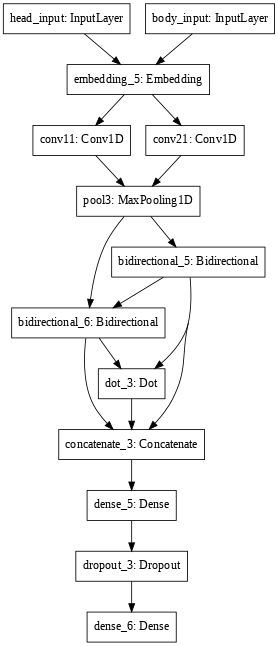

In [0]:
print(max_body,max_head)
print(embed_dim)
print(vocab_size)
print(embed_matrix.shape)
head_input = Input(shape=(max_head,), name='head_input')
body_input = Input(shape=(max_body,), name='body_input')
shared_embed = Embedding(vocab_size,embed_dim,weights=[embed_matrix],trainable=False)  #embed_dim instead of 10
head_embed = shared_embed(head_input)
body_embed = shared_embed(body_input)

conv_11 = layers.Conv1D(64, 5, activation='relu', name='conv11')
conv_12 = layers.Conv1D(64, 5, activation='relu', name='conv12')
conv_21 = layers.Conv1D(32, 3, activation='relu', name='conv21')
conv_22 = layers.Conv1D(32, 3, activation='relu', name='conv22')
#pooling layers
pool_3 = MaxPooling1D(pool_size=3, strides=2, name='pool3')
pool_4 = MaxPooling1D(pool_size=3, strides=2, name='pool4')

head_CNN = conv_11(head_embed)
head_CNN = pool_3(head_CNN)
head_CNN = conv_21(head_CNN)
head_CNN = pool_4(head_CNN)
head_CNN = Flatten()(head_CNN)

body_CNN = conv_12(body_embed)
body_CNN = pool_3(body_CNN)
body_CNN = conv_22(body_CNN)
body_CNN = pool_4(body_CNN)
body_CNN = Flatten()(body_CNN)

conc = concatenate([head_CNN,body_CNN])
dense = Dense(100,activation='relu')(conc)
dense = Dropout(0.3)(dense)
dense = Dense(4,activation='softmax')(dense)
model = Model(inputs=[head_input,body_input], outputs=dense)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
# train_text=np.array(train_text)
# train_body=np.array(train_body)
# tf.convert_to_tensor(arg, dtype=tf.float32)
for i in range(5):
    model.fit([train_text,train_body],y_train,epochs=30, batch_size=64,verbose = True)
    # evaluate_answer(model,[test_text,test_body],y_test)
model.save("fake.h5")

Epoch 1/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0778 - acc: 0.9708
Epoch 2/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0776 - acc: 0.9712
Epoch 3/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0723 - acc: 0.9730
Epoch 4/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0702 - acc: 0.9742
Epoch 5/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0726 - acc: 0.9742
Epoch 6/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0636 - acc: 0.9765
Epoch 7/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0638 - acc: 0.9772
Epoch 8/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0646 - acc: 0.9782
Epoch 9/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0600 - acc: 0.9785
Epoch 10/30
781/781 [==============================] - 10s 13ms/step - loss: 0.0612 - acc: 0.9786
Epoch 11/30
781/781 [========